In [ ]:
from functools import partial
from pathlib import Path

from fastcore.xtras import Path

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers.data.data_collator import default_data_collator

from composer import Trainer
from composer.models import HuggingFaceModel
from composer.metrics import CrossEntropy
from composer.loggers import WandBLogger

from torchmetrics import F1Score

In [ ]:
path = Path('../data')

In [ ]:
path.ls()

(#3) [Path('../data/Train.csv'),Path('../data/test.csv'),Path('../data/Sample Submission.csv')]

In [ ]:
train_df = pd.read_csv(path/'Train.csv', index_col='Id')
test_df = pd.read_csv(path/'test.csv', index_col='Id')

In [ ]:
train_df

,description,medical_specialty,sample_name,transcription
Id,,,,
1,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
2,The patient is an 84-year-old female presente...,Cardiovascular / Pulmonary,Pericardial Effusion,"REASON FOR CONSULTATION:, Pericardial effusio..."
3,Hand dermatitis.,Dermatology,Dermatitis - SOAP,"SUBJECTIVE:, This is a 29-year-old Vietnamese..."
4,Recurrent degenerative spondylolisthesis and ...,Surgery,Lumbar Re-exploration,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati..."
5,Chiropractic IME with old files review. Deta...,IME-QME-Work Comp etc.,Chiropractic IME - 2,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI..."
...,...,...,...,...
3380,Morbid obesity. Laparoscopic Roux-en-Y gastr...,Surgery,Laparoscopic Gastric Bypass - 1,"PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POS..."
3381,"Lateral and plantar condylectomy, fifth left ...",Surgery,Condylectomy,"TITLE OF OPERATION:, Lateral and plantar cond..."
3382,Right heart and left heart catheterization by...,Surgery,Cardiac Catheterization - 6,"PRECATHETERIZATION DIAGNOSIS (ES):, Hypoplasti..."


In [ ]:
train_df.describe(include='object')

,description,medical_specialty,sample_name,transcription
count,3384,3384,3384,3360
unique,1800,35,1825,1810
top,Common description of colonoscopy,Surgery,Lumbar Discogram,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO..."
freq,10,788,5,5


In [ ]:
train_df.medical_specialty.unique()

array([' Cardiovascular / Pulmonary', ' Dermatology', ' Surgery',
       ' IME-QME-Work Comp etc.', ' General Medicine', ' Orthopedic',
       ' Gastroenterology', ' Pain Management',
       ' Consult - History and Phy.', ' Radiology',
       ' Hematology - Oncology', ' Neurology', ' Nephrology', ' Podiatry',
       ' Office Notes', ' Rheumatology', ' Neurosurgery',
       ' Endocrinology', ' Discharge Summary', ' Bariatrics',
       ' SOAP / Chart / Progress Notes', ' ENT - Otolaryngology',
       ' Ophthalmology', ' Letters', ' Cosmetic / Plastic Surgery',
       ' Dentistry', ' Physical Medicine - Rehab',
       ' Psychiatry / Psychology', ' Autopsy', ' Sleep Medicine',
       ' Speech - Language', ' Allergy / Immunology',
       ' Lab Medicine - Pathology', ' Chiropractic', ' SCARF type'],
      dtype=object)

In [ ]:
sample = train_df.iloc[0]

In [ ]:
sample.description

' Patient had a recurrent left arm pain after her stent, three days ago, and this persisted after two sublingual nitroglycerin.'

In [ ]:
sample.medical_specialty

' Cardiovascular / Pulmonary'

In [ ]:
sample.sample_name

' Angina - Consult '

In [ ]:
sample.transcription

'HISTORY OF PRESENT ILLNESS: , The patient is a 68-year-old woman whom I have been following, who has had angina.  In any case today, she called me because she had a recurrent left arm pain after her stent, three days ago, and this persisted after two sublingual nitroglycerin when I spoke to her.  I advised her to call 911, which she did.  While waiting for 911, she was attended to by a physician who is her neighbor and he advised her to take the third nitroglycerin and that apparently relieved her pain.  By the time she presented here, she is currently pain-free and is feeling well.,PAST CARDIAC HISTORY: , The patient has been having arm pain for several months.  She underwent an exercise stress echocardiogram within the last several months with me, which was equivocal, but then she had a nuclear stress test which showed inferobasilar ischemia.  I had originally advised her for a heart catheterization but she wanted medical therapy, so we put her on a beta-blocker.  However, her arm p

In [ ]:
train_df.medical_specialty.value_counts()

medical_specialty
 Surgery                          788
 Consult - History and Phy.       310
 Cardiovascular / Pulmonary       309
 Orthopedic                       294
 Radiology                        225
 Gastroenterology                 189
 General Medicine                 188
 Neurology                        166
 SOAP / Chart / Progress Notes    130
 ENT - Otolaryngology              79
 Discharge Summary                 75
 Neurosurgery                      73
 Hematology - Oncology             72
 Nephrology                        69
 Ophthalmology                     64
 Pain Management                   55
 Podiatry                          43
 Office Notes                      35
 Dermatology                       23
 Psychiatry / Psychology           22
 Dentistry                         21
 Cosmetic / Plastic Surgery        19
 Letters                           18
 Physical Medicine - Rehab         17
 Sleep Medicine                    17
 Endocrinology                  

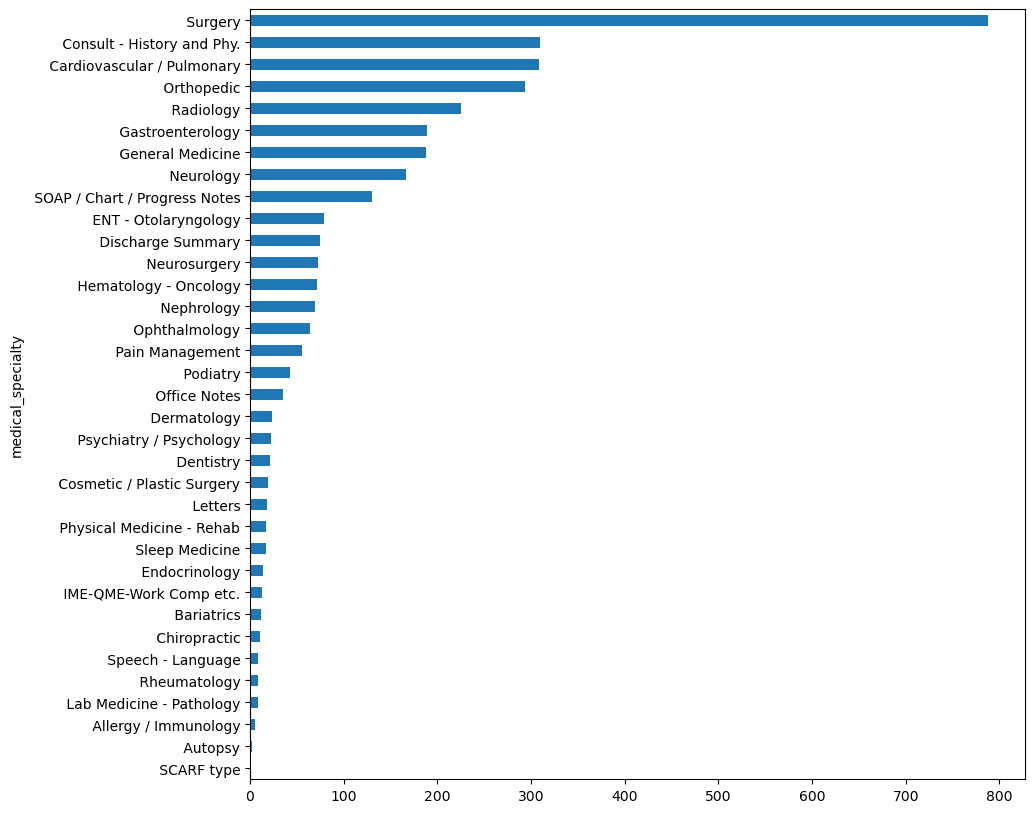

In [ ]:
train_df.medical_specialty.value_counts(ascending=True).plot.barh(figsize=(10, 10));

In [ ]:
train_df.sample_name.value_counts()

sample_name
 Lumbar Discogram                              5
 Burn - Consult                                4
 Normal ENT Exam - 1                           4
 Chest Pain & Respiratory Insufficiency        4
 Normal ENT Exam                               4
                                              ..
 Septoplasty & Turbinectomy                    1
 Foot Pain - SOAP                              1
 Inguinal Hernia Repair - 3                    1
 Laparoscopic Orchiopexy                       1
 Therapeutic Recreation Initial Evaluation     1
Name: count, Length: 1825, dtype: int64

In [ ]:
test_df.sample_name.value_counts()

sample_name
 Teeth Extraction & I&D            2
 Scleral Buckle Opening            2
 Radical Mastectomy                2
 Uveitis                           2
 Resection of Tumor of Scalp       2
                                  ..
 Septoplasty & Turbinectomy        1
 Styloidectomy                     1
 SOAP - Lung Mass                  1
 Pericardial Effusion              1
 Hematuria & Urinary Retention     1
Name: count, Length: 291, dtype: int64

In [ ]:
# check if there are any sample names in the test set that are not in the train set
len(set(test_df.sample_name.unique()) - set(train_df.sample_name.unique()))

36

In [ ]:
# check if there are any sample names in the train set that are not in the test set
len(set(train_df.sample_name.unique()) - set(test_df.sample_name.unique()))

1570

In [ ]:
def process_df(df, sep_token):
    df["input"] = df.description
    df.input = df.input.str.lower()
    return df


In [ ]:
train_df = process_df(train_df, sep_token='[SEP]')

In [ ]:
train_df.head()

,description,medical_specialty,sample_name,transcription,input
Id,,,,,
1,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a...",patient had a recurrent left arm pain after h...
2,The patient is an 84-year-old female presente...,Cardiovascular / Pulmonary,Pericardial Effusion,"REASON FOR CONSULTATION:, Pericardial effusio...",the patient is an 84-year-old female presente...
3,Hand dermatitis.,Dermatology,Dermatitis - SOAP,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",hand dermatitis.
4,Recurrent degenerative spondylolisthesis and ...,Surgery,Lumbar Re-exploration,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati...",recurrent degenerative spondylolisthesis and ...
5,Chiropractic IME with old files review. Deta...,IME-QME-Work Comp etc.,Chiropractic IME - 2,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI...",chiropractic ime with old files review. deta...


In [ ]:
def create_val_split(df: pd.DataFrame, val_prop: float = 0.2, seed: int = 42):
    sample_name = df.sample_name.unique()
    np.random.seed(seed)
    np.random.shuffle(sample_name)
    val_sz = int(len(sample_name) * val_prop)
    val_sample_name = sample_name[:val_sz]
    is_val = np.isin(df.sample_name, val_sample_name)
    idxs = np.arange(len(df))
    val_idxs = idxs[is_val]
    trn_idxs = idxs[~is_val]

    return trn_idxs, val_idxs

In [ ]:
trn_idxs, val_idxs = create_val_split(train_df)

In [ ]:
len(trn_idxs), len(val_idxs)

(2699, 685)

In [ ]:
# train_df['words_per_input'] = train_df.input.str.split().apply(len)
# # train_df.boxplot("words_per_input", by="medical_specialty", grid=False, showfliers=False, color="black")
# # box plot of the 10 most common medical specialties
# train_df[train_df.medical_specialty.isin(train_df.medical_specialty.value_counts().head(10).index)].boxplot(
#     "words_per_input", by="medical_specialty", grid=False, showfliers=False, color="black", figsize=(20, 10));

In [ ]:
checkpoint = "microsoft/deberta-v3-small"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/eleven/mambaforge/envs/nlpbook/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def tokenize_func(batch, tokenizer):
    return tokenizer(
        batch["input"],
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

In [ ]:
sample

description           Patient had a recurrent left arm pain after h...
medical_specialty                           Cardiovascular / Pulmonary
sample_name                                          Angina - Consult 
transcription        HISTORY OF PRESENT ILLNESS: , The patient is a...
Name: 1, dtype: object

In [ ]:
tokenizer(sample.description)

{'input_ids': [1, 14064, 330, 266, 23714, 595, 3123, 1427, 385, 342, 34636, 261, 475, 538, 824, 261, 263, 291, 29328, 385, 375, 96822, 119250, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
# create label to int dict
label2int = {label: i for i, label in enumerate(train_df.medical_specialty.unique())}
int2label = {v: k for k, v in label2int.items()}

In [ ]:
label2int

{' Cardiovascular / Pulmonary': 0,
 ' Dermatology': 1,
 ' Surgery': 2,
 ' IME-QME-Work Comp etc.': 3,
 ' General Medicine': 4,
 ' Orthopedic': 5,
 ' Gastroenterology': 6,
 ' Pain Management': 7,
 ' Consult - History and Phy.': 8,
 ' Radiology': 9,
 ' Hematology - Oncology': 10,
 ' Neurology': 11,
 ' Nephrology': 12,
 ' Podiatry': 13,
 ' Office Notes': 14,
 ' Rheumatology': 15,
 ' Neurosurgery': 16,
 ' Endocrinology': 17,
 ' Discharge Summary': 18,
 ' Bariatrics': 19,
 ' SOAP / Chart / Progress Notes': 20,
 ' ENT - Otolaryngology': 21,
 ' Ophthalmology': 22,
 ' Letters': 23,
 ' Cosmetic / Plastic Surgery': 24,
 ' Dentistry': 25,
 ' Physical Medicine - Rehab': 26,
 ' Psychiatry / Psychology': 27,
 ' Autopsy': 28,
 ' Sleep Medicine': 29,
 ' Speech - Language': 30,
 ' Allergy / Immunology': 31,
 ' Lab Medicine - Pathology': 32,
 ' Chiropractic': 33,
 ' SCARF type': 34}

In [ ]:
train_df

,description,medical_specialty,sample_name,transcription,input
Id,,,,,
1,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a...",patient had a recurrent left arm pain after h...
2,The patient is an 84-year-old female presente...,Cardiovascular / Pulmonary,Pericardial Effusion,"REASON FOR CONSULTATION:, Pericardial effusio...",the patient is an 84-year-old female presente...
3,Hand dermatitis.,Dermatology,Dermatitis - SOAP,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",hand dermatitis.
4,Recurrent degenerative spondylolisthesis and ...,Surgery,Lumbar Re-exploration,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati...",recurrent degenerative spondylolisthesis and ...
5,Chiropractic IME with old files review. Deta...,IME-QME-Work Comp etc.,Chiropractic IME - 2,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI...",chiropractic ime with old files review. deta...
...,...,...,...,...,...
3380,Morbid obesity. Laparoscopic Roux-en-Y gastr...,Surgery,Laparoscopic Gastric Bypass - 1,"PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POS...",morbid obesity. laparoscopic roux-en-y gastr...
3381,"Lateral and plantar condylectomy, fifth left ...",Surgery,Condylectomy,"TITLE OF OPERATION:, Lateral and plantar cond...","lateral and plantar condylectomy, fifth left ..."
3382,Right heart and left heart catheterization by...,Surgery,Cardiac Catheterization - 6,"PRECATHETERIZATION DIAGNOSIS (ES):, Hypoplasti...",right heart and left heart catheterization by...


In [ ]:
# create target column to replace medical_specialty
train_df['labels'] = train_df.medical_specialty.map(label2int)

In [ ]:
train_df

,description,medical_specialty,sample_name,transcription,input,labels
Id,,,,,,
1,Patient had a recurrent left arm pain after h...,Cardiovascular / Pulmonary,Angina - Consult,"HISTORY OF PRESENT ILLNESS: , The patient is a...",patient had a recurrent left arm pain after h...,0
2,The patient is an 84-year-old female presente...,Cardiovascular / Pulmonary,Pericardial Effusion,"REASON FOR CONSULTATION:, Pericardial effusio...",the patient is an 84-year-old female presente...,0
3,Hand dermatitis.,Dermatology,Dermatitis - SOAP,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",hand dermatitis.,1
4,Recurrent degenerative spondylolisthesis and ...,Surgery,Lumbar Re-exploration,"PREOPERATIVE DIAGNOSIS: , Recurrent degenerati...",recurrent degenerative spondylolisthesis and ...,2
5,Chiropractic IME with old files review. Deta...,IME-QME-Work Comp etc.,Chiropractic IME - 2,"DATE OF INJURY : October 4, 2000,DATE OF EXAMI...",chiropractic ime with old files review. deta...,3
...,...,...,...,...,...,...
3380,Morbid obesity. Laparoscopic Roux-en-Y gastr...,Surgery,Laparoscopic Gastric Bypass - 1,"PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POS...",morbid obesity. laparoscopic roux-en-y gastr...,2
3381,"Lateral and plantar condylectomy, fifth left ...",Surgery,Condylectomy,"TITLE OF OPERATION:, Lateral and plantar cond...","lateral and plantar condylectomy, fifth left ...",2
3382,Right heart and left heart catheterization by...,Surgery,Cardiac Catheterization - 6,"PRECATHETERIZATION DIAGNOSIS (ES):, Hypoplasti...",right heart and left heart catheterization by...,2


In [ ]:
def tokenize_and_split(df, tokenize_func, train=True):
    remove_columns = ["sample_name", "input", "transcription"]
    dataset = datasets.Dataset.from_pandas(df)
    tok_dataset = dataset.map(
        tokenize_func,
        batched=True,
        batch_size=None,
        remove_columns=remove_columns
    )
    if train:
        # remove_columns.append("medical_specialty")
        trn_idxs, val_idxs = create_val_split(df)
        tok_dataset = datasets.DatasetDict(
        {"train": tok_dataset.select(trn_idxs), "test": tok_dataset.select(val_idxs)}
    )
    
    return tok_dataset

In [ ]:
def create_dataloaders(tok_ds, bs, train=True):
    if train:
        train_dl = DataLoader(
            tok_ds["train"],
            batch_size=bs,
            shuffle=True,
            collate_fn=default_data_collator,
            drop_last=True
        )
        val_dl = DataLoader(
            tok_ds["test"],
            batch_size=bs,
            shuffle=False,
            collate_fn=default_data_collator,
            drop_last=False
        )

        return train_dl, val_dl
    else:
        test_dl = DataLoader(
            tok_ds,
            batch_size=bs,
            shuffle=False,
            collate_fn=default_data_collator,
        )

        return test_dl

In [ ]:
def prepare_data(df, tokenizer, sep_token, bs, training=True):
    if training:
        train_df = process_df(df, sep_token)
        tokenize = partial(tokenize_func, tokenizer=tokenizer)
        train_tok_ds = tokenize_and_split(train_df, tokenize)
        train_dl, val_dl = create_dataloaders(train_tok_ds, bs)
        
        return train_dl, val_dl
    else:
        test_df = process_df(df, sep_token)
        tokenize = partial(tokenize_func, tokenizer=tokenizer)
        test_tok_ds = tokenize_and_split(test_df, tokenize, train=False)
        test_dl = create_dataloaders(test_tok_ds, bs, train=False)
        
        return test_dl

In [ ]:
def prepare_optimizer_and_scheduler(model, lr, wd, epochs, train_dl):
    optimizer = AdamW(
        params=model.parameters(),
        lr=lr,
        betas=(0.9, 0.98),
        eps=1e-6,
        weight_decay=wd,
    )
    scheduler = OneCycleLR(
        optimizer,
        max_lr=lr,
        steps_per_epoch=len(train_dl),
        epochs=epochs,
    )
    
    return optimizer, scheduler

In [ ]:
def prepare_model(checkpoint, tokenizer, num_labels):
    f1_score = F1Score(task='multiclass', num_classes=num_labels)
    model = AutoModelForSequenceClassification.from_pretrained(
        checkpoint,
        num_labels=num_labels,
    )
    hf_model = HuggingFaceModel(
        model,
        tokenizer=tokenizer,
        metrics=[CrossEntropy(), f1_score],
        use_logits=True
    )
    
    return hf_model

In [ ]:
def prepare_trainer(composer_model, 
                    optimizer, 
                    scheduler, 
                    train_dl, 
                    val_dl, 
                    epochs, 
                    run_name):
    trainer = Trainer(
        model=composer_model,
        train_dataloader=train_dl,
        eval_dataloader=val_dl,
        max_duration=f"{epochs}ep",
        optimizers=optimizer,
        schedulers=[scheduler],
        loggers=[WandBLogger(project="medical-specialty-classification")],
        run_name=run_name,
        device="gpu",
        precision="amp_fp16",
        step_schedulers_every_batch=True,
        # seed=17,
    )
    
    return trainer

def fit(train_df,
        checkpoint,
        run_name, 
        bs=32, 
        lr=2e-5, 
        wd=0.01, 
        epochs=4, 
        num_labels=len(label2int), 
        sep_token="[SEP]"):
    # preparing data
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    train_dl, val_dl = prepare_data(train_df, tokenizer, sep_token, bs)
    model = prepare_model(checkpoint, tokenizer, num_labels)
    
    
    # preparing optimizer and scheduler
    optimizer, scheduler = prepare_optimizer_and_scheduler(model, 
                                                           lr, 
                                                           wd, 
                                                           epochs, 
                                                           train_dl)
                                                           
    
    # preparing trainer
    trainer = prepare_trainer(model, 
                              optimizer, 
                              scheduler, 
                              train_dl, 
                              val_dl, 
                              epochs, 
                              run_name)
    
    # training
    trainer.fit()
    
    return trainer

def predict(trainer, test_dl):
    preds = trainer.predict(test_dl)[0]["logits"].numpy().astype(float)
    preds = np.clip(preds, 0, 1)
    preds = preds.round(2)
    preds = preds.squeeze()

    return preds

In [ ]:
8e-5 * 2

0.00016

In [ ]:
bs, lr, wd, epochs = 128, 8e-5, 0.01, 4
num_labels = len(label2int)
checkpoint = "microsoft/deberta-v3-small"
run_name = "test"

trainer = fit(train_df, 
              checkpoint, 
              run_name=run_name, 
              bs=bs, 
              lr=lr, 
              wd=wd, 
              epochs=epochs,
              num_labels=num_labels,
              sep_token="[SEP]")
print(trainer.state.eval_metric_values)

# trainer.close()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/eleven/mambaforge/envs/nlpbook/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceCl

******************************
Config:
node_name: ubuntu_desktop
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 105132114

******************************


train          Epoch   0:    0%|| 0/21 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/6 [00:00<?, ?ba/s]         

/home/eleven/mambaforge/envs/nlpbook/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 45 into batches of size 128. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/21 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/6 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/21 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/6 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/21 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/6 [00:00<?, ?ba/s]         

{'CrossEntropy': tensor(2.5141, device='cuda:0'), 'MulticlassF1Score': tensor(0.3299, device='cuda:0')}


In [ ]:
test_dl = prepare_data(test_df, tokenizer, sep_token="[SEP]", bs=len(test_df), training=False)

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# one batch of test_dl
batch = next(iter(test_dl))

In [ ]:
def predict(trainer, test_dl, int2label):
    preds = trainer.predict(test_dl)[0]["logits"].argmax(1).numpy().astype(int)
    preds = preds.tolist()
    preds = [int2label[pred] for pred in preds]
    return preds

In [ ]:
batch

{'Id': tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
          43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
          57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
          71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
          85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
          99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
         113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
         127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
         141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
         155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
         169, 170, 171, 172, 173, 174, 175, 17

In [ ]:
preds = trainer.predict(test_dl)[0]["logits"].argmax(1).numpy().astype(int)
preds.tolist()[:5]

[9, 2, 9, 2, 9]

In [ ]:
string_preds = [int2label[pred] for pred in preds]

In [ ]:
string_preds[:5]

[' Radiology', ' Surgery', ' Radiology', ' Surgery', ' Radiology']

In [ ]:
test_df.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312],
      dtype='int64', name='Id', length=312)

In [ ]:
# create submission
submission = pd.DataFrame({"Id": test_df.index, "medical_specialty": string_preds})
# submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()

,Id,medical_specialty
0,1,Radiology
1,2,Surgery
2,3,Radiology
3,4,Surgery
4,5,Radiology


## Debugging Section

In [ ]:
checkpoint = "microsoft/deberta-v3-small"
sep_token = "[SEP]"
bs = 128
lr = 8e-5
wd = 0.01
epochs = 4
num_labels = len(label2int)
run_name = "baseline"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
train_dl, val_dl = prepare_data(train_df, tokenizer, sep_token, bs)
model = prepare_model(checkpoint, tokenizer, num_labels)


# preparing optimizer and scheduler
optimizer, scheduler = prepare_optimizer_and_scheduler(model, 
                                                        lr, 
                                                        wd, 
                                                        epochs, 
                                                        train_dl)
                                                        

# preparing trainer
trainer = prepare_trainer(model, 
                            optimizer, 
                            scheduler, 
                            train_dl, 
                            val_dl, 
                            epochs, 
                            run_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/eleven/mambaforge/envs/nlpbook/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3384 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceCl

loss/train/total,███████▇▇▆▅▄▄▄▃▃▄▃▃▃▃▂▃▃▂▂▂▂▂▂▃▁▃▁▃▁▂▁▃▂
metrics/eval/CrossEntropy,█▃▁▁
metrics/eval/MulticlassF1Score,▁▅██
metrics/train/CrossEntropy,███████▇▇▆▆▄▄▄▄▄▄▃▃▃▃▃▂▃▂▃▂▂▃▂▂▂▃▂▁▂▂▁▂▂
metrics/train/MulticlassF1Score,▁▁▁▂▁▂▂▂▃▄▄▅▅▄▄▅▅▆▅▆▆▆▆▆▆▆▇▇▇▆▆▆▅▆█▇▇▇▆▆
time/batch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/batch_in_epoch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▇▇█▁▂▃▄▅▅▆▇▇▁
time/epoch,▁▃▅▆█
time/sample,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/sample_in_epoch,▁▂▂▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▇▇█▁▂▃▄▅▅▆▇▇▁
time/token,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [ ]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-06
    foreach: None
    fused: None
    initial_lr: 3.2000000000000003e-06
    lr: 3.1999999999999965e-06
    max_lr: 8e-05
    max_momentum: 0.95
    maximize: False
    min_lr: 3.2000000000000003e-10
    weight_decay: 0.01
)

In [ ]:
scheduler

<torch.optim.lr_scheduler.OneCycleLR>

: 